In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import time
from DUT import DUT
import matplotlib.pyplot as plt
import numpy as np
import json
import sys

import pandas as pd

from tqdm import tqdm

In [3]:
my_dut = DUT(20, True, 3.2)

In [4]:
n_train = 5000
n_test = 20000 - n_train

In [5]:
meastime, nmeas, nport, meas, ports, expyield = my_dut.info()
print("DUT: meas. time= ", meastime, " | measurements= ", nmeas, " | ports= ", nport, " | expected yield = ", expyield)

DUT: meas. time=  128.43814099999997  | measurements=  45  | ports=  12  | expected yield =  3.2


In [6]:
error_count = 0
X = []
Y = []
t=0

data= {}
data['component']=[]

In [7]:
fails = []
my_err = 0

In [8]:
for x in range(n_train):    
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]
    
    if x % 500 == 0:
        my_dut.calibrate()
        
    toggle = True

    for i in range(0, nmeas):
        t, result, dist = my_dut.gen_meas_idx(i)
        
        if dist > 1: fails.append(i)
        
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
                
        if result == False and toggle:
            toggle = False
            my_err += 1
            break

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  0.1  took  532.1566359999999  seconds.
Calibration at  63406.97392400085  took  532.1566359999999  seconds.
Calibration at  126480.46737600658  took  532.1566359999999  seconds.
Calibration at  189951.40386501866  took  532.1566359999999  seconds.
Calibration at  252390.55489503022  took  532.1566359999999  seconds.
Calibration at  315311.24285699526  took  532.1566359999999  seconds.
Calibration at  378137.2136869518  took  532.1566359999999  seconds.
Calibration at  441090.83380390814  took  532.1566359999999  seconds.
Calibration at  504284.04286186455  took  532.1566359999999  seconds.
Calibration at  567742.3717218406  took  532.1566359999999  seconds.


In [9]:
a, c = np.unique(fails, return_counts=True)
indexes = np.zeros(nmeas)
indexes[a] = c
sorted_meas = np.argsort(-indexes)

sorted_meas #= sorted_meas # [:-sum(indexes < 1)]

array([40,  2,  8,  3,  4,  5, 20,  0,  1,  7, 33, 18, 28, 36, 17, 15, 13,
       11,  9,  6, 16, 14, 10, 35, 26, 27, 32, 31, 39, 37, 34, 22, 29, 25,
       24, 43, 21, 19, 30, 23, 38, 12, 41, 42, 44])

In [10]:
for x in range(n_test):
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]

    if x % 500 == 0:
        my_dut.calibrate()
    
    incount = True
    for j, i in enumerate(sorted_meas):
        t, result, dist = my_dut.gen_meas_idx(i, incount)
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
        
        if result == False or j > nmeas - sum(indexes < 1):
            if result == False and incount:
                my_err +=1
            incount = False

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  630890.4446348255  took  532.1566359999999  seconds.
Calibration at  687327.3879957987  took  532.1566359999999  seconds.
Calibration at  743425.950844772  took  532.1566359999999  seconds.
Calibration at  799909.7880307457  took  532.1566359999999  seconds.
Calibration at  856648.0241867192  took  532.1566359999999  seconds.
Calibration at  913629.9147226926  took  532.1566359999999  seconds.
Calibration at  969581.2135036662  took  532.1566359999999  seconds.
Calibration at  1026558.9724236394  took  532.1566359999999  seconds.
Calibration at  1083531.5698797537  took  532.1566359999999  seconds.
Calibration at  1139818.577423952  took  532.1566359999999  seconds.
Calibration at  1196378.085582152  took  532.1566359999999  seconds.
Calibration at  1252907.9581263524  took  532.1566359999999  seconds.
Calibration at  1309223.2354445516  took  532.1566359999999  seconds.
Calibration at  1365461.3131767507  took  532.1566359999999  seconds.
Calibration at  1421891.905279

Total:  2329227.7173473034 s  15000  (  961  |  901  |  961  ) ==>  0.9359333333333333
950


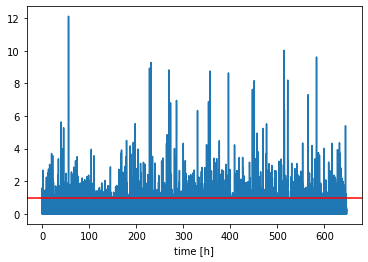

In [11]:
error_dut, error_meas = my_dut.get_errordutcount()
print("Total: ",t, "s ", x+1, " ( ", error_count, " | ", error_dut, " | ", error_meas, " ) ==> ", (x+1-error_count)/(x+1) )
print(my_err)
# write json log
# outfile = open('result.json', 'w')
# json.dump(data, outfile, indent=2)

# plot results
timeAxis = [x / 3600. for x in X]
plt.xlabel('time [h]')
plt.plot(timeAxis,Y)
plt.axhline(y=1., xmin=0, xmax=1, color='r')
plt.show()